In [1]:
# import Pkg
# Pkg.add("SpecialFunctions")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%                                  57.1%#                           66.5%
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [276daf66] + SpecialFunctions v0.10.3
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
#Pkg.build("Plots")
using Plots
using Random
using StatsBase
using Distributions
using GLM 
using DataFrames
using CSV
using LinearAlgebra
using SpecialFunctions

Get from Hellewell PCR positivity curve

In [3]:
df = DataFrame(CSV.File("/Users/carlwhitfield/Documents/Github/pcr-profile/PCR_curve_summary.csv"))
dfL = DataFrame(CSV.File("/Users/carlwhitfield/Documents/Github/pcr-profile/LFT_curve_summary.csv"))

,days_since_infection,median,lower_95,upper_95
,Float64,Float64,Float64,Float64
1,0.0,0.00342482,0.000160892,0.0168156
2,0.1,0.00413469,0.000214018,0.0193613
3,0.2,0.00499732,0.000278157,0.0219235
4,0.3,0.00599365,0.000352528,0.0257078
5,0.4,0.00717554,0.00044684,0.0301376
6,0.5,0.00853067,0.000564725,0.0356469
7,0.6,0.0102175,0.000729167,0.0427771
8,0.7,0.0121769,0.00091984,0.0513494
9,0.8,0.0146323,0.00117667,0.061558


Assume there is some actual viral load, which is given in log10 copies / ml.

Assume there is some sigmoidal probability that swab acquires a +ve sample (this dependence is completely fabricated).

PCR is 1:1 with swab positivity above absolute cutoff

LFD has failure rate compared to PCR determined by Porton Down estimates. This seems sensible given very low "false positive" rates.

Assume peak infectivity is correlated to peak viral load through the odds ratio relation in Marks' Catalonia paper. Allow some noise around this.

VL trajectories from Bayesian model fitted in Kissler paper (NBA players)

In [4]:
function ct_toVL_kissler(ct)
    return log10(250) + (ct - 40.93733)/(-3.60971)
end

function ct_toVL_peto(ct)
   return VL = 11.19 - 0.304*(ct - 4.4) 
end

ct_toVL_peto (generic function with 1 method)

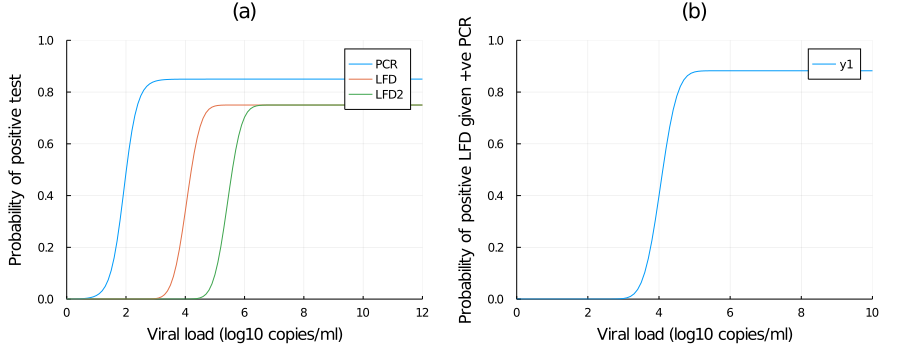

In [55]:
peakVL_mean = 7.533
peakVL_sd = 1.164

pasymp_vl7 = 0.65
pasymp_vl89 = 0.5
pasymp_vl10 = 0.35
asymp_frac = cdf(Normal(peakVL_mean,peakVL_sd),7.0)*pasymp_vl7 + 
    (cdf(Normal(peakVL_mean,peakVL_sd),9.0) - cdf(Normal(peakVL_mean,peakVL_sd),7.0))*pasymp_vl89 +
    (1 - cdf(Normal(peakVL_mean,peakVL_sd),9.0))*pasymp_vl10
X = 1.3

PIsigma = 0.5
PImu = -0.5*PIsigma^2

function logistic_func(x::Float64, b::Array{Float64,1})
    return 1/(1 + exp(-b[2]*x - b[1]))
end

function probit_func(x::Float64, b::Array{Float64,1})
    return cdf(Normal(-b[1]/b[2],1/b[2]),x)
end

VLrange = 0.0:0.1:12.0
sens_max_PCR = 0.85
sens_max_LFD = 0.75
b_PCR = [-8.52, 4.41]
b_LFD = [-10.84, 2.68]
b_LFD2 = [-ct_toVL_kissler(30)*2.68, 2.68]

Ptest = sens_max_PCR .* logistic_func.(VLrange, Ref(b_PCR))
Ltest = sens_max_LFD .* probit_func.(VLrange, Ref(b_LFD))
Ltest2 = sens_max_LFD .* probit_func.(VLrange, Ref(b_LFD2))

Plots.plot(VLrange, Ptest,label="PCR",xlim=(0,12),ylim=(0,1))
Plots.plot!(VLrange, Ltest,label="LFD")
plot1 = Plots.plot!(VLrange, Ltest2,label="LFD2",xlim=(0,12),ylim=(0,1),xlabel="Viral load (log10 copies/ml)",
    ylabel="Probability of positive test",title="(a)")
#plot2 = Plots.scatter(VLrange, Itest,label="Relative Peak Infectivity",xlim=(0,12),ylim=(0,10.0))
plot3 = Plots.plot(VLrange, Ltest ./ Ptest,xlim=(0,10),ylim=(0,1),xlabel="Viral load (log10 copies/ml)",
    ylabel="Probability of positive LFD given +ve PCR",title="(b)")
plot(plot1,plot3,layout=(1,2),size=(900,350),margin=5Plots.mm)
#Plots.savefig("LFD_PCR_VLdep.png")

Let's generate some profiles at random, assuming that VL peaks on average at 
symptom time but with about half S.D than symptom time

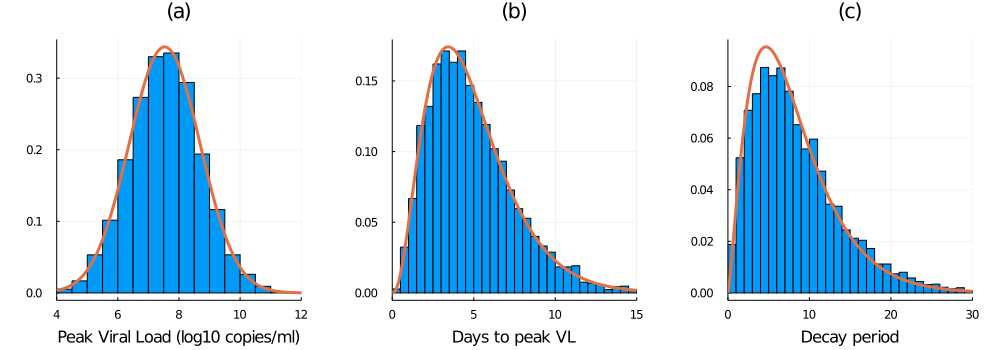

In [61]:
dt = 0.1
t = 0:dt:30
N=5000
startVL = -3
VLdetect = ct_toVL_kissler(40)
VLinfcutoff = 6.0
j0scale = 4.0/(exp(log(X)^2*peakVL_sd^2/2)*(1 + 
        erf((peakVL_mean - VLinfcutoff + log(X)*peakVL_sd^2)/(sqrt(2)*peakVL_sd))))
PVLs = rand(Normal(peakVL_mean,peakVL_sd),N)  #kissler data
OTs = rand(Gamma(1.1,1.0/0.7),N)
PTs = rand(Gamma(2.3,1.0/0.7),N)
DTs = rand(Gamma(10.5*0.3,1.0/0.3),N)    #gen_decay_time.(-ones(N))
function generate_asymptomatics(VL::Array{Float64,1})
    #randomly generate if people are asymptomatic
    nr = 1:length(VL)
    nVL7 = nr[VL .< 7]
    nVL89 = nr[(VL .>= 7) .* (VL .<= 9)]
    nVL10 = nr[VL .> 9]
    return vcat(randsubseq(nVL7,pasymp_vl7),randsubseq(nVL89,pasymp_vl89),
                randsubseq(nVL10,pasymp_vl10))
end
As = generate_asymptomatics(PVLs)
DTs[As] = rand(Gamma(6.7*0.3,1.0/0.3),length(As))
function Peak_Infectivity(VL::Float64, symp::Bool, VLscale::Float64, x::Float64)
    value = j0scale*X^(VL - VLscale)
    r = rand(LogNormal(PImu,PIsigma))
    return r*value
end

Plots.histogram(PVLs,bins=20,xlim=(4,12),normed=true,label=:none,xlabel="Peak Viral Load (log10 copies/ml)")
x1 = collect(4.:0.1:12.0)
plot1 = Plots.plot!(x1,pdf(Normal(7.53, 1.16),x1),bins=20,w=3,label=:none,title="(a)")
Plots.histogram(OTs + PTs,xlim=(0,15),normed=true, xlabel="Days to peak VL",label=:none,)
x2 = collect(0.0:0.1:15.0)
plot2 = Plots.plot!(x2,pdf(Gamma(3.4,1.0/0.7),x2),bins=20,w=3,label=:none,title="(b)")
Plots.histogram(DTs,xlim=(0,30),normed=true,xlabel="Decay period",label=:none)
x3 = 0.0:0.1:30.0
plot3 = Plots.plot!(x3,pdf(Gamma(2.4,1.0/0.3),x3),w=3,label=:none,title="(c)")
Plots.plot(plot1,plot2,plot3,layout=(1,3),size=(1000,350),margin=5Plots.mm)

#Plots.savefig("VL_distributions.png")

7.354978332620506 7.755286680201698
2.007391630285035 2.2122231883742955
0.5362

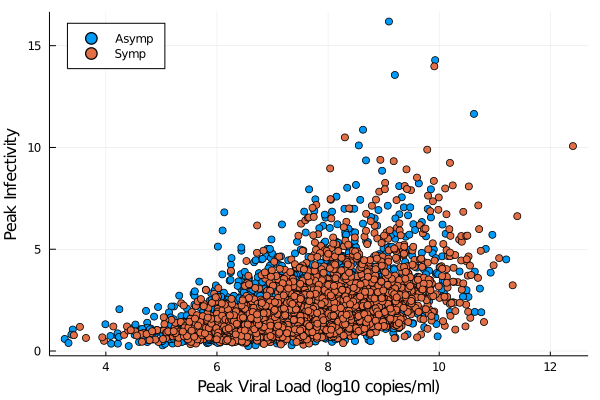

In [62]:
symp = ones(Bool,length(PVLs))
symp[As] .= false
print(mean(PVLs[As]),' ', mean(PVLs[symp]),'\n')
j0 = Peak_Infectivity.(PVLs, symp, Ref(peakVL_mean), Ref(X))
print(mean(j0[As]),' ', mean(j0[symp]),'\n')
print(length(As)/length(PVLs))
scatter(PVLs[As], j0[As],label="Asymp")
scatter!(PVLs[symp], j0[symp],xlabel="Peak Viral Load (log10 copies/ml)", 
         ylabel="Peak Infectivity",label="Symp",legend=:topleft)

#Plots.savefig("Inf_VL_relation.png")

Plot mean test positivity profiles

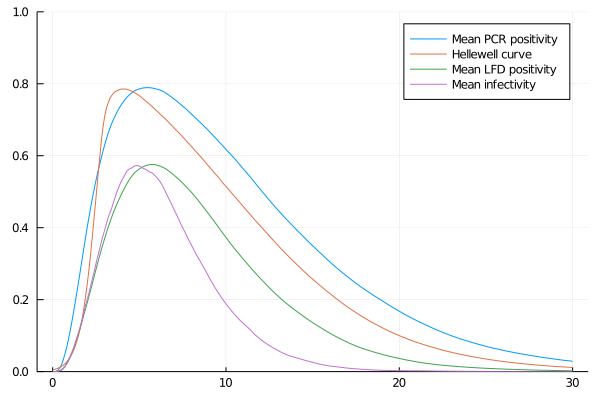

In [63]:
v = zeros(N,length(t))
j = zeros(N,length(t))
for n in 1:N
    m_up = (PVLs[n] - startVL)/(OTs[n] + PTs[n])
    m_down = (PVLs[n] - VLdetect)/DTs[n]
    cond1 = (t .<= OTs[n] + PTs[n])
    v[n,cond1] = startVL .+ m_up .* t[cond1]
    cond2 = ((t .> OTs[n] + PTs[n]))
    v[n,cond2] = PVLs[n] .- m_down .* (t[cond2] .- OTs[n] .- PTs[n])
#     if PVLs[n] > VLinfcutoff
#         jt0 = (VLinfcutoff - startVL)/m_up
#         cond3 = cond1 .* (t .>= jt0)
#         j[n,cond3] = j0[n] .* (t[cond3] .- jt0) ./ (OTs[n] + PTs[n] - jt0)
#         jtd = (PVLs[n] - VLinfcutoff)/m_down
#         cond4 = cond2 .* (t .<= OTs[n] + PTs[n] + jtd)
#         j[n,cond4] = j0[n] .* (1 .- (t[cond4] .- PTs[n] .- OTs[n]) ./ (jtd))
#         if n == 2
#             print(OTs[n] + PTs[n],' ',jt0,' ', jtd,'\n')
#             print(j[n,cond3],' ',j[n,cond4], '\n')
#         end
#     end
end
j[v .> VLinfcutoff] = (v[v .> VLinfcutoff] .- VLinfcutoff)
j = Diagonal(j0 ./ (PVLs .- VLinfcutoff)) *j


p = zeros(N,length(t))
LFDp = zeros(N,length(t))
xh = 1.3


p = sens_max_PCR .* logistic_func.(v, Ref(b_PCR))
LFDp = sens_max_LFD .* probit_func.(v, Ref(b_LFD))
LFDp2 = sens_max_PCR .* probit_func.(v, Ref(b_LFD2))

Plots.plot(t,transpose(mean(p,dims=1)),ylim=(0,1),label="Mean PCR positivity")
Plots.plot!(t,df["median"],ylim=(0,1),label="Hellewell curve")
Plots.plot!(t,transpose(mean(LFDp,dims=1)),ylim=(0,1),label="Mean LFD positivity")
Plots.plot!(t,transpose(mean(j,dims=1)),ylim=(0,1),label="Mean infectivity")

Plot the viral loads

8
Mean number of days infectious: 3.20088


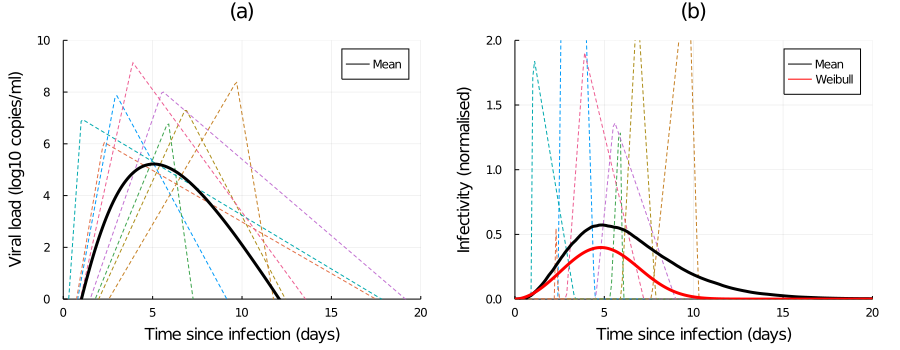

In [64]:
selected = sample(1:N,8,replace=false)
print(length(selected),'\n')
print("Mean number of days infectious: ", sum(j .> 0)*dt/N,'\n')
Plots.plot(t,transpose(v[selected,:]),xlim=(0,20),ylim=(0,10),s=:dash,alpha=1,label=:none)
plot1 = Plots.plot!(t,transpose(mean(v,dims=1)),c="black",lw=3,label="Mean",xlabel="Time since infection (days)",
ylabel="Viral load (log10 copies/ml)",title="(a)")

Plots.plot(t,transpose(j[selected,:]),xlim=(0,20),ylim=(0,4.0),s=:dash,alpha=1.0,label=:none)
Plots.plot!(t,transpose(mean(j,dims=1)),ylim=(0,2.0),c="black",lw=3,label="Mean",
    xlabel="Time since infection (days)", ylabel="Infectivity (normalised)",title="(b)")
plot2 = Plots.plot!(t, 2*pdf(Weibull(2.83,5.61),t),c="red",lw=3,label="Weibull")
Plots.plot(plot1,plot2,layout=(1,2),size=(900,350),margin=5Plots.mm)
#Plots.savefig("VL_trajectories.png")


Plot the PCR Test Positivity and Plot LFD positivity

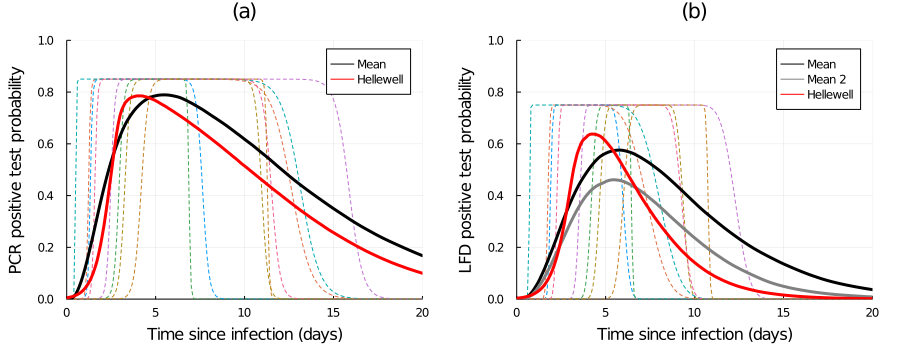

In [65]:

Plots.plot(t,transpose(p[selected,:]),ylim=(0,1),s=:dash,alpha=1,label=:none)
Plots.plot!(t,transpose(mean(p,dims=1)),xlim=(0,20),ylim=(0,1),c="black",lw=3,label="Mean")
plot1 = Plots.plot!(df["days_since_infection"],df["median"],lw=3,c="red",label="Hellewell",xlabel="Time since infection (days)",
ylabel="PCR positive test probability",title="(a)")

Plots.plot(t,transpose(LFDp[selected,:]),xlim=(0,20),ylim=(0,1),s=:dash,alpha=1,label=:none)
Plots.plot!(t,transpose(mean(LFDp,dims=1)),ylim=(0,1),c="black",lw=3,label="Mean")
Plots.plot!(t,transpose(mean(LFDp2,dims=1)),ylim=(0,1),c="grey",lw=3,label="Mean 2")
plot2 = Plots.plot!(dfL["days_since_infection"],dfL["median"],lw=3,c="red",label="Hellewell",
    xlabel="Time since infection (days)", ylabel="LFD positive test probability",title="(b)")
Plots.plot(plot1,plot2,layout=(1,2),size=(900,350),margin=5Plots.mm)
#Plots.savefig("Test_positivity.png")

Plot the infectivity profiles

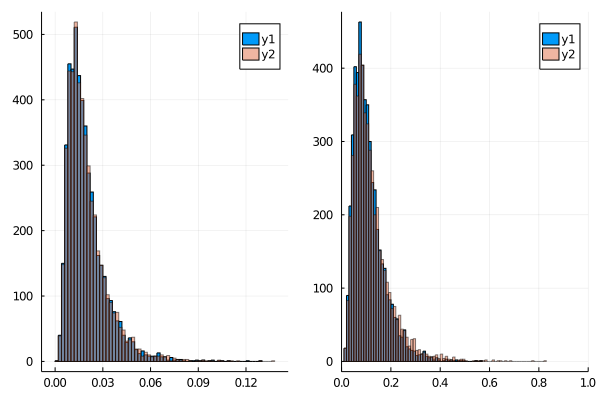

In [49]:
#Suppose beta = 0.01 or 0.2 (least to most intense contacts)
p1 = 1 .- exp.(-0.01 .* j0)
p2 = 1 .- exp.(-0.06 .* j0)
Plots.histogram(p1)
plot1 = Plots.histogram!(0.01 .* j0, alpha=0.5)
Plots.histogram(p2)
plot2 = Plots.histogram!(0.06 .* j0,xlim=(0,1), alpha=0.5)
Plots.plot(plot1,plot2)

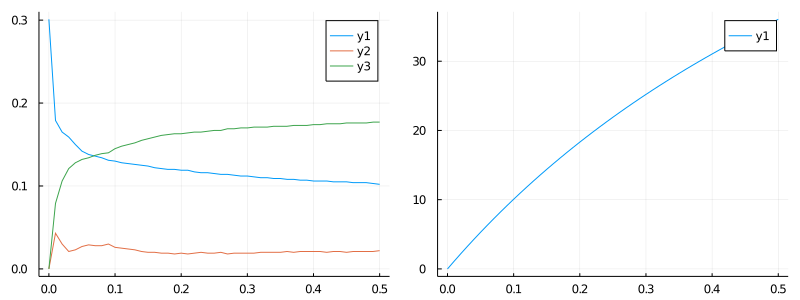

In [44]:
beta = 0.0:0.01:0.5
FR0 = zeros(length(beta))
FR1 = zeros(length(beta))
FRg1 = zeros(length(beta))
Rav = zeros(length(beta))
for (i,bt) in enumerate(beta)
    Ppcpd = 1 .- exp.(- bt .* j)
    FR0[i] = sum(sum(Ppcpd,dims=1)*dt .< 0.05)/N
    FR1[i] = (sum((sum(Ppcpd,dims=1)*dt .>= 0.05) .* (sum(Ppcpd,dims=1)*dt .< 0.15)))/N
    FRg1[i] = sum(sum(Ppcpd,dims=1)*dt .>= 0.15)/N
    Rav[i] = mean(sum(Ppcpd,dims=1)*dt).*10
end
plot(beta, FR0)
plot!(beta, FR1)
p1 = plot!(beta, FRg1)
p2 = plot(beta, Rav)
plot(p1,p2,layout=(1,2),size=(800,300))

Problem is that test positive rates are much better than the average. 

Can show this by e.g. multiplying test positive rates by infectious prob. Then averaging and normalising by mean infection prob

In [180]:
Ppcpd = 1 .- exp.(- 0.1 .* j)
we = mean(p.*Ppcpd,dims=1)./mean(Ppcpd,dims=1)
we1 = mean(LFDp.*Ppcpd,dims=1)./mean(Ppcpd,dims=1)

1×1000 Array{Float64,2}:
 0.633617  0.738922  0.517166  0.73635  …  0.764893  0.666608  0.666981

Then compare this to same calculation but for the median profiles

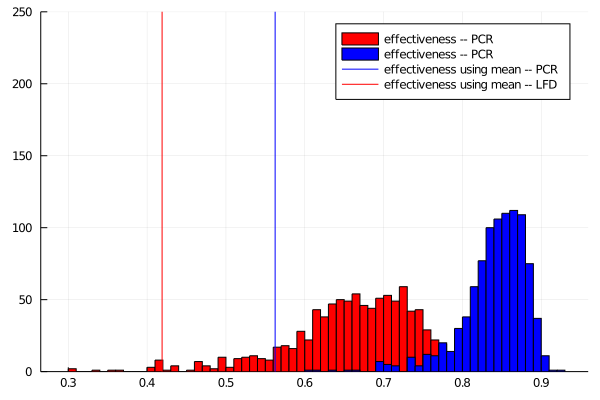

In [181]:
wemean = mean(mean(p,dims=2).*mean(Ppcpd,dims=2),dims=1) / mean(Ppcpd)
we1mean = mean(mean(LFDp,dims=2).*mean(Ppcpd,dims=2),dims=1) / mean(Ppcpd)
Plots.histogram(transpose(we1),bins=50,c="red",label="effectiveness -- PCR")
Plots.histogram!(transpose(we),bins=50,c="blue",label="effectiveness -- PCR")
Plots.plot!([wemean;wemean],[0;N],c="blue",label="effectiveness using mean -- PCR")
Plots.plot!([we1mean;we1mean],[0;N],c="red",ylim=(0,250),label="effectiveness using mean -- LFD")

The amount the mean profiles actually differ will depend on noise and the 
interdependence of these processes that are assumed
to have 1:1 relationships (like Ct and infectivity)

1.2432290637117596